In [4]:
import os, time
import getpass

import mlflow
from configs import DAGSHUB_USER_NAME, DAGSHUB_REPO_NAME, MODEL_DIR, DEVICE
from utils import get_experiment_id, get_last_run_id

from fewshotdataloader import generate_loader, CARS

from utils import evaluate, precision_recall_curve, compute_prototypes

import numpy as np

import matplotlib.pyplot as plt

from protonet import PrototypicalNetworks

import torch
import pandas as pd

from torchvision.models import resnet18
import onnx
import onnxruntime as ort

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [5]:
mlflow.set_tracking_uri(f'https://dagshub.com/{DAGSHUB_USER_NAME}/{DAGSHUB_REPO_NAME}.mlflow')

In [6]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'afhabibieee'
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass.getpass('enter pass: ')

In [7]:
def do_inference(
        run_id,
        n_way=5,
        n_shot=5,
        n_query=5,
        n_task=100,
):
        # dataset
        test_set = CARS(split='test', image_size=84)

        test_loader = generate_loader(
                'test',
                image_size=84,
                n_way=n_way,
                n_shot=n_shot,
                n_query=n_query,
                n_task=n_task,
                n_workers=2
        )

        # download model
        if not os.path.exists(os.path.join(MODEL_DIR, run_id)):
                mlflow.artifacts.download_artifacts(
                        run_id=run_id,
                        artifact_path='model',
                        dst_path=os.path.join(MODEL_DIR, run_id)
                )
        print("Artifacts downloaded in: {}".format(MODEL_DIR))

        # Load model
        logged_model = f'runs:/{run_id}/model'
        loaded_model = mlflow.pytorch.load_model(logged_model)
        print(f'run id: {run_id}')

        avg_accuracy, _, _, results, avg_time = evaluate(loaded_model, test_loader, test_set)

        result_path = f'../models/results/{run_id}.csv'
        with open(result_path, 'w') as file:
                for result in results:
                        file.write("%s\n" %result)
        
        thresholds = np.arange(start=0.4, stop=0.96, step=0.05)
        precisions, recalls, f1 = precision_recall_curve(result_path, thresholds)
        idx_f1_max = np.argmax(f1)

        desc = f"""
                {loaded_model.__class__.__name__} ({loaded_model.backbone.__class__.__name__})

                Setup:
                    ({n_way}-way; {n_shot}-shot; {n_query}-query)
                
                Desc:   
                    On average, the accuracy of {n_task} tasks in data 
                    testing using a {DEVICE.type.upper()} was {avg_accuracy:.3f}, with a processing 
                    time of {avg_time:.2f} seconds. The best F1 score was {f1[idx_f1_max]:.3f}, 
                    with recalls of {recalls[idx_f1_max]:.3f} and precisions of {precisions[idx_f1_max]:.3f}. The 
                    threshold confidence score for these results was {thresholds[idx_f1_max]:.2f}.
                """
        font = {'size': 11, 'color': 'grey', 'style': 'italic', 'family': 'Comic Sans MS'}
        plt.style.use('ggplot')
        plt.xlim([min(recalls)+.002, 1])
        plt.ylim([min(precisions)-.002, 1])
        plt.plot(recalls[idx_f1_max], precisions[idx_f1_max], '-ro')
        plt.plot(recalls, precisions, linewidth=2, color="red")
        plt.xlabel("Recall", fontdict=font, fontweight='bold')
        plt.ylabel("Precision", fontdict=font, fontweight='bold')
        plt.title("Precision-Recall Curve", fontdict=font, fontsize=15, fontweight="bold")
        plt.text(1.0002, min(precisions)+.0002, desc, fontdict=font)
        plt.show()

# A model trained with 5-way 5-shot

Artifacts downloaded in: ../models/saved model


2022/12/09 05:21:41 WARNING mlflow.pytorch: Stored model version '1.12.1+cu102' does not match installed PyTorch version '1.13.0+cpu'


run id: c647a2612ffb4440930a5b17da7ab462


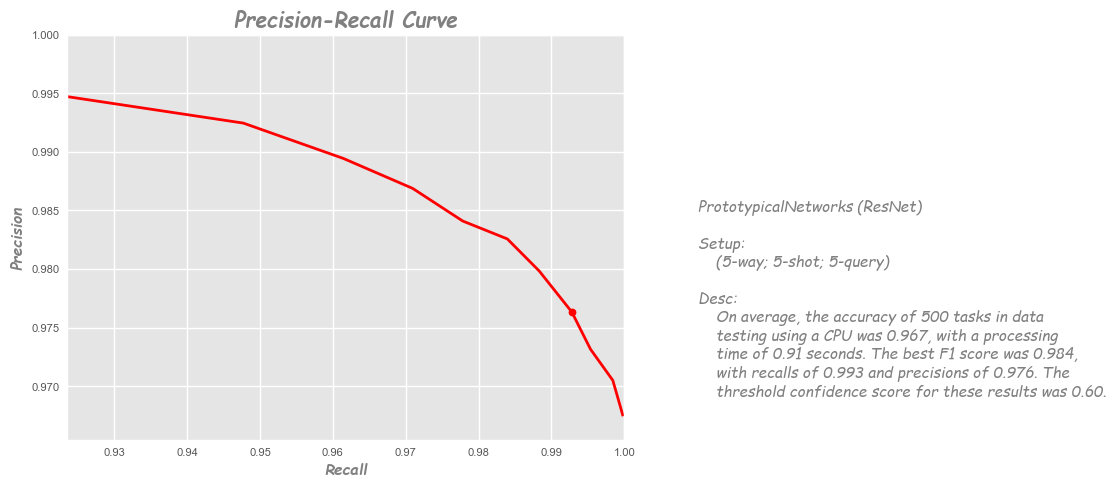

In [292]:
# first model
run_id = 'c647a2612ffb4440930a5b17da7ab462'
do_inference(run_id, n_task=500)

Artifacts downloaded in: ../models/saved model


2022/12/09 05:30:19 WARNING mlflow.pytorch: Stored model version '1.12.1+cu102' does not match installed PyTorch version '1.13.0+cpu'


run id: abbda0848d0e4aacb6bdcd1eeb0694d8


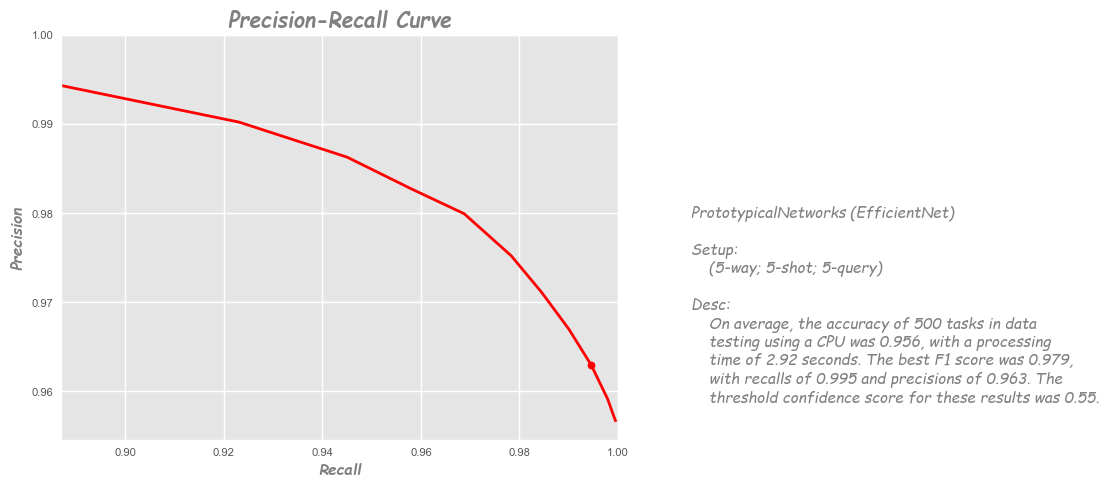

In [293]:
# second model
run_id = 'abbda0848d0e4aacb6bdcd1eeb0694d8'
do_inference(run_id, n_task=500)

Artifacts downloaded in: ../models/saved model


2022/12/09 05:56:31 WARNING mlflow.pytorch: Stored model version '1.12.1+cu102' does not match installed PyTorch version '1.13.0+cpu'


run id: b270c73d063e49949583c0485b56f065


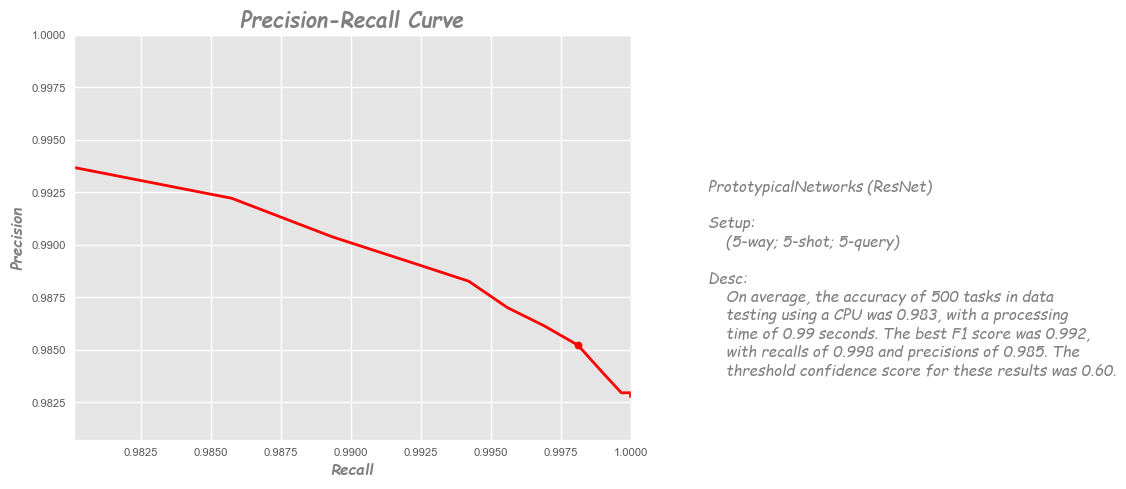

In [294]:
# third model (BEST MODEL)
run_id = 'b270c73d063e49949583c0485b56f065'
do_inference(run_id, n_task=500)

Artifacts downloaded in: ../models/saved model


2022/12/28 19:27:52 WARNING mlflow.pytorch: Stored model version '1.13.0+cu117' does not match installed PyTorch version '1.13.0+cpu'


run id: 29c41059df454eac99e5b20ef35a8b55


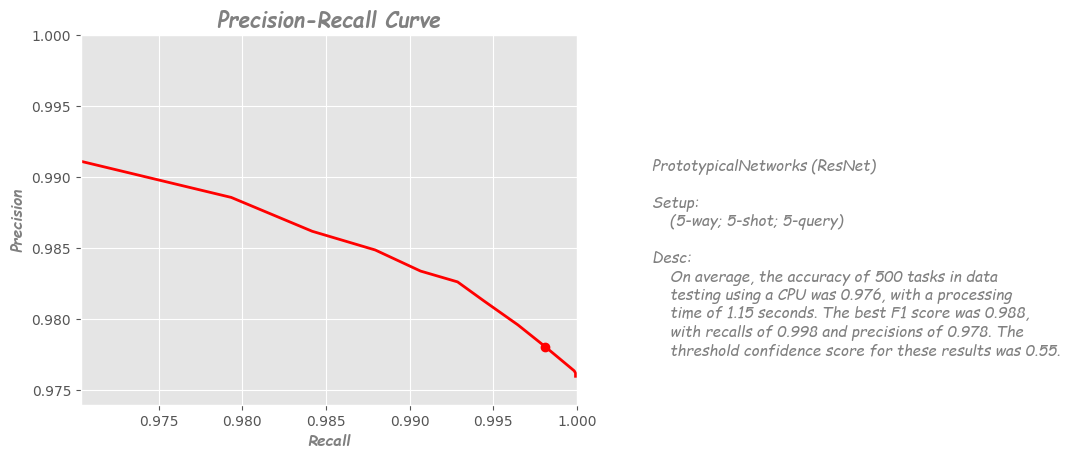

In [8]:
# fourth model (BEST MODEL with CV2 for post processing)
run_id = '29c41059df454eac99e5b20ef35a8b55'
do_inference(run_id, n_task=500)

# A model trained with 10-way 5-shot

Artifacts downloaded in: ../models/saved model


2022/12/09 11:59:22 WARNING mlflow.pytorch: Stored model version '1.12.1+cu102' does not match installed PyTorch version '1.13.0+cpu'


run id: 026303d4836a4e659851c86ac7d65a0a


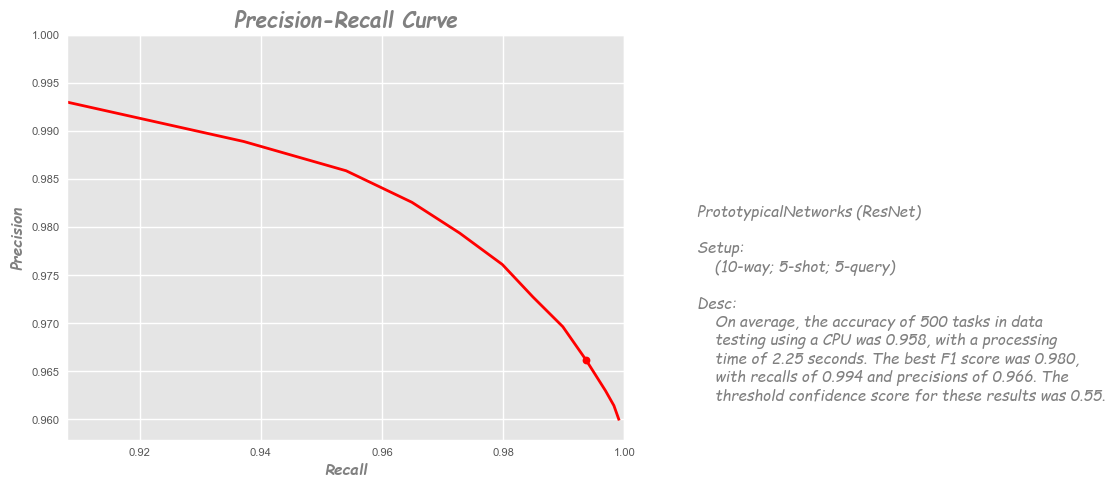

In [300]:
# fourth model
run_id = '026303d4836a4e659851c86ac7d65a0a'
do_inference(run_id, n_way=10, n_task=500)

Artifacts downloaded in: ../models/saved model


2022/12/09 12:20:02 WARNING mlflow.pytorch: Stored model version '1.12.1+cu102' does not match installed PyTorch version '1.13.0+cpu'


run id: 026303d4836a4e659851c86ac7d65a0a


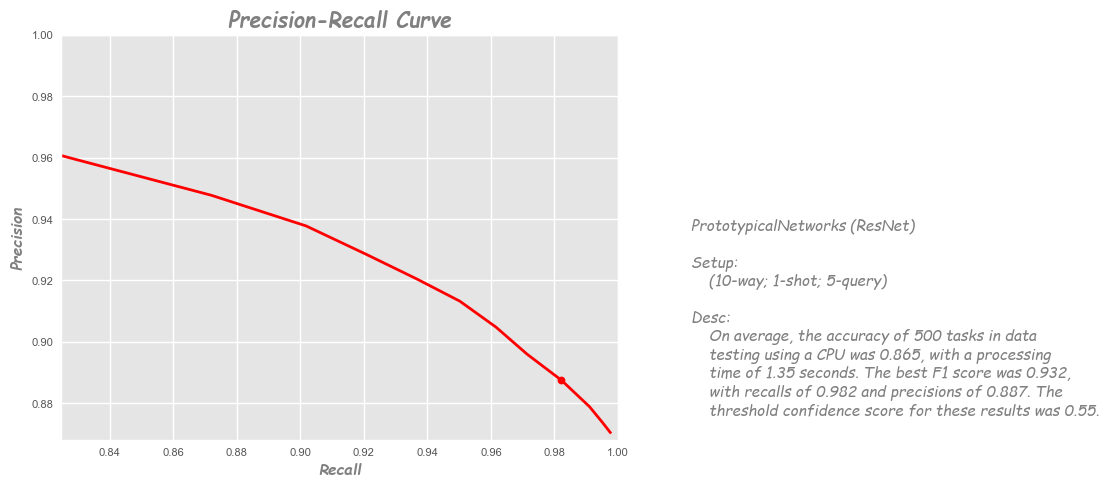

In [301]:
# fourth model
run_id = '026303d4836a4e659851c86ac7d65a0a'
do_inference(run_id, n_way=10, n_shot=1, n_task=500)

# Benchmarking the differences between n-way and n-shot with the best model

In [4]:
def benchmark(loaded_model, n_ways, n_shots, metrics):
    results = []
    for n_way in n_ways:
        result = []
        for n_shot in n_shots:
            test_set = CARS(split='test', image_size=84)
            test_loader = generate_loader(
                'test',
                n_way=n_way,
                n_shot=n_shot,
                n_query=5,
                n_task=500,
                n_workers=8
            )
            avg_accuracy, avg_recall, avg_precision, _, _ = evaluate(loaded_model, test_loader, test_set)
            result.extend([avg_accuracy, avg_recall, avg_precision])
        results.append(result)
    
    header = [
        [f"{shot}-shot" for shot in n_shots for i in range(len(metrics))],
        [*[metric for metric in metrics]*len(n_shots)]
    ]

    df = pd.DataFrame(
        results,
        index=[f"{way}-way" for way in n_ways], 
        columns = header
    )
    
    return df.style.set_caption("Selected Best Model Inference Benchmarks").set_table_styles([{
        'selector': 'caption',
        'props': [
            ('font-size', '20px')
        ]
    }])

In [9]:
# Save state_dict
run_id = '29c41059df454eac99e5b20ef35a8b55'
logged_model = f'../models/saved model/{run_id}/model/data/model.pth'
best_model_path = '../models/best model/model.pt'
loaded_model = torch.load(logged_model).to(DEVICE).eval()
torch.save(loaded_model.state_dict(), best_model_path)

In [10]:
# Load state_dict
model = PrototypicalNetworks(backbone_name='resnet', variant_depth='18', dropout=0.5)
model.load_state_dict(torch.load(best_model_path))
model = model.to(DEVICE).eval()

Within this repository, you can use `'loaded_model'`, but it is recommended to use `'state_dict_model'` when working outside the repository to avoid dependency on specific modules.

In [6]:
n_ways = [5, 10, 15, 20]
n_shots = [1, 5, 10]
metrics = ['accuracy', 'precision', 'recall']
results = benchmark(loaded_model, n_ways, n_shots, metrics)

In [9]:
results

In [11]:
results.data.to_csv('../models/benchmarks.csv', index=True, header=True)

In [12]:
# Ploting benchmarks
def plot_benchmark(metric):
    font = {'size': 11, 'color': 'grey', 'style': 'italic', 'family': 'Comic Sans MS'}
    plt.style.use('ggplot')
    columns = [i if metric=='Accuracy' else i+1 if metric=='Precision' else i+2 for i in [0, 3, 6]]
    for i in columns:
        plt.plot((n_ways), results.data.iloc[:, i], '-o', label=results.data.columns[i][0])
    plt.xticks(n_ways, results.data.index)
    plt.title(f'Average {metric} by K-Way and K-Shot', fontdict=font, fontsize=15, fontweight="bold")
    plt.ylabel(f'Average {metric}', fontdict=font, fontweight='bold')
    plt.ylim(top=1)
    plt.legend()
    plt.show()

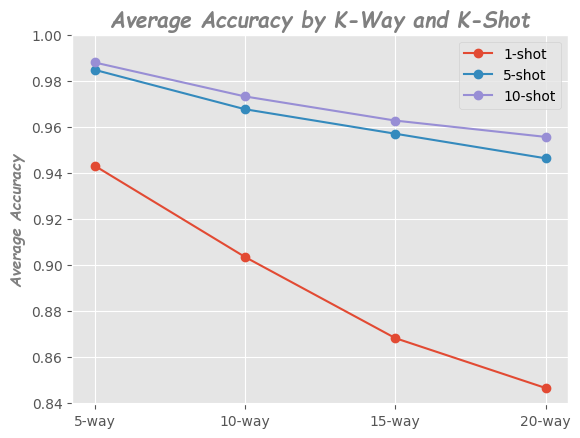

In [13]:
plot_benchmark('Accuracy')

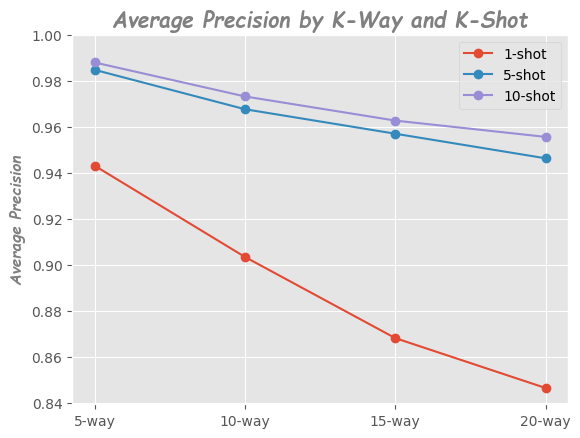

In [14]:
plot_benchmark('Precision')

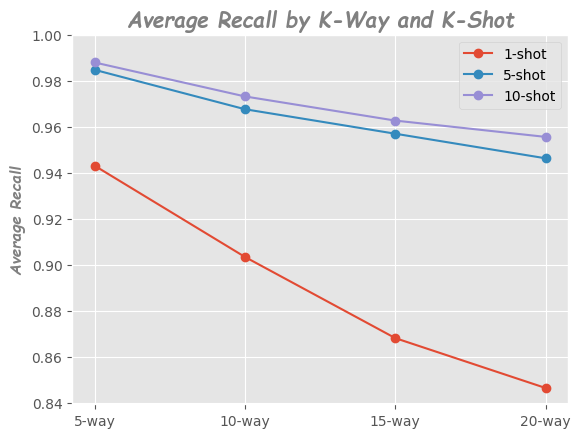

In [15]:
plot_benchmark('Recall')

# Inference Scheme of ONNX Model with Its Embedding

In [11]:
class Embeddings(torch.nn.Module):
    def __init__(self, dropout=None):
        super(Embeddings, self).__init__()
        trunk = []
        
        self.backbone = resnet18(weights=None)

        if dropout: trunk.append(torch.nn.Dropout(dropout))
        trunk.append(torch.nn.Flatten())
        
        self.backbone.fc = torch.nn.Sequential(*trunk)

    def forward(self, x):
        x = self.backbone(x)
        return x

In [12]:
embedding = Embeddings(dropout=0.5)
embedding.load_state_dict(torch.load(best_model_path))
embedding = embedding.to(DEVICE).eval()

The architecture of this embedding class is customized to the best selected model (`Protonets` with a `resnet18` backbone and a dropout of `0.5`). This will differ if using a different pre-trained model.

In [13]:
# Exporting an ONNX model
dummy_input = torch.rand(1,3,84,84)
ONNX_FILE_PATH = '../models/best model/embedding.onnx'
dynamic_axes={
    "input":{0:"n_way_shot"},
    "output":{0:"n_way_shot"}
}

try:
    torch.onnx.export(
        embedding, 
        dummy_input,
        ONNX_FILE_PATH, 
        input_names=["input"],
        output_names=['output'], 
        dynamic_axes=dynamic_axes
    )
except Exception as e:
    print(f'export failed {e}')

In [14]:
(
    example_support_image,
    example_support_label,
    example_query_image,
    example_query_label,
    example_class_id
) = next(iter(
    generate_loader(
        'test',
        image_size=84,
        n_way=5,
        n_shot=5,
        n_query=10,
        n_task=1,
        n_workers=8
    )
))

There are no limitations on the number of images and variety of classes in the query image, however in this case there are 50 queries with 10 images for each of the 5 classes.

In [15]:
example_support_image.shape, example_support_label.shape, example_query_image.shape

(torch.Size([25, 3, 84, 84]), torch.Size([25]), torch.Size([50, 3, 84, 84]))

In [19]:
# Run the model with ONNX runtime
ort_session = ort.InferenceSession(ONNX_FILE_PATH)

start = time.time()
support_features = ort_session.run(None, {'input': example_support_image.cpu().numpy()})
support_features = torch.from_numpy(support_features[0]).to(DEVICE)

query_features = ort_session.run(None, {'input': example_query_image.cpu().numpy()})
query_features = torch.from_numpy(query_features[0]).to(DEVICE)

prototypes = compute_prototypes(support_features, example_support_label)

dists = torch.cdist(query_features, prototypes)
scores = -dists.detach()

top_soft_prob, pred_labels = torch.max(
    scores.data.softmax(-1), 1
)
end = time.time()
time_exec = (end-start)
        
print('\nThe time of inference with {} for one task is : {} s'.format(DEVICE.type.upper(), time_exec))
print('\nshape: {}'.format(scores.shape))
print('\n{}'.format(top_soft_prob))


The time of inference with CPU for one task is : 0.9487490653991699 s

shape: torch.Size([50, 5])

tensor([1.0000, 1.0000, 1.0000, 0.8764, 1.0000, 1.0000, 1.0000, 0.9914, 1.0000,
        0.9999, 1.0000, 0.9999, 0.9999, 0.9999, 1.0000, 1.0000, 0.9984, 1.0000,
        1.0000, 1.0000, 0.9999, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9997, 1.0000, 1.0000, 1.0000, 1.0000, 0.9584, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6496, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
